<a name="TF-KS"></a>
## **Hyperparameter Selection**

Table of contents:
- [Learning Curve](#Loss-plot)
- [Hyperparameter Tuning](#Tuning)

In [1]:
#import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.optimizers import Adam 

#from tensorflow.keras import initializers

from sklearn.metrics import accuracy_score#confusion_matrix, 
#import seaborn as sns
import matplotlib.pyplot as plt  

from sklearn.model_selection import GridSearchCV
#from keras.models import Sequential
#from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

<a name="Dataset"></a>
## **Dataset**


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
data = pd.read_csv("/content/drive/My Drive/auto-mpg.csv", na_values='?', usecols=["MPG","Cylinders","Displacement","Horsepower","Weight","Acceleration","Model Year"])
data = data.dropna()
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
0,18.0,8,307.0,130.0,3504,12.0,70
1,15.0,8,350.0,165.0,3693,11.5,70
2,18.0,8,318.0,150.0,3436,11.0,70
3,16.0,8,304.0,150.0,3433,12.0,70
4,17.0,8,302.0,140.0,3449,10.5,70


In [4]:
data.shape

(392, 7)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('MPG', axis=1), data['MPG'], test_size=0.3, random_state=42)

In [6]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [7]:
#Z-score Normalizing
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_val = preprocessing.scale(X_val)
X_test = preprocessing.scale(X_test)

<a name="Loss-plot"></a>
## **Learning Curve**


In [8]:
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=X_train.shape[1]))
model.add(Dense(4, activation = 'relu')) # kernel_initializer= initializers.glorot_uniform(seed=42)
model.add(Dense(2, activation = 'relu')) # 64, kernel_initializer= initializers.glorot_uniform(seed=42)
model.add(Dense(1, activation='relu'))

In [9]:
model.compile(loss="mean_absolute_error") 

In [10]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val,y_val))

Epoch 1/20
9/9 [==============================] - 3s 24ms/step - loss: 23.5815 - val_loss: 22.8628
Epoch 2/20
9/9 [==============================] - 0s 6ms/step - loss: 23.5601 - val_loss: 22.8466
Epoch 3/20
9/9 [==============================] - 0s 6ms/step - loss: 23.5424 - val_loss: 22.8301
Epoch 4/20
9/9 [==============================] - 0s 6ms/step - loss: 23.5234 - val_loss: 22.8134
Epoch 5/20
9/9 [==============================] - 0s 6ms/step - loss: 23.5034 - val_loss: 22.7945
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 23.4819 - val_loss: 22.7753
Epoch 7/20
9/9 [==============================] - 0s 6ms/step - loss: 23.4609 - val_loss: 22.7547
Epoch 8/20
9/9 [==============================] - 0s 6ms/step - loss: 23.4368 - val_loss: 22.7299
Epoch 9/20
9/9 [==============================] - 0s 6ms/step - loss: 23.4109 - val_loss: 22.7044
Epoch 10/20
9/9 [==============================] - 0s 6ms/step - loss: 23.3860 - val_loss: 22.6805
Epoch 11/20
9/9 [=

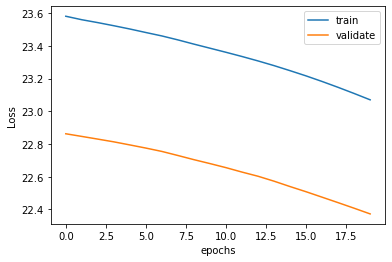

In [11]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Accuracy (Root Mean Squared Error)
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

23.91705274234213

<a name="Tuning"></a>
<h1> Hyperparameter Tuning </h1>
<a href="https://imgbb.com/"><img src="https://i.ibb.co/W3WZC8d/tune.png" alt="tune" border="0"></a>

In [13]:
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, neurons_1=1, neurons_2=1):
  # create model
  model = tf.keras.Sequential()
  model.add(InputLayer(input_shape=X_train.shape[1]))
  model.add(Dense(neurons_1, activation = 'relu'))
  model.add(Dense(neurons_2, activation = 'relu'))
  model.add(Dense(1, activation='relu'))

	# Compile model
  optimizer = Adam(learning_rate=learn_rate)
  model.compile(loss='mean_absolute_error', optimizer= optimizer, metrics=['accuracy'])
  return model

In [14]:
# Wrap model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_model)

In [15]:
# define the grid search parameters
hyperparameters = dict(learn_rate = [0.001, 0.01], 
                       neurons_1=[4, 32],
                       neurons_2=[2, 16]) 
hyperparameters 

{'learn_rate': [0.001, 0.01], 'neurons_1': [4, 32], 'neurons_2': [2, 16]}

In [16]:
# Conduct Grid Search

# Create grid search
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters, n_jobs=-1, cv=5)

# Fit grid search
grid_result = grid.fit(X_train, y_train)

9/9 [==============================] - 0s 4ms/step - loss: 37.6971 - accuracy: 0.0036


In [17]:
# Find best model's hyperparameters
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

0.007273 (0.008907) with: {'learn_rate': 0.001, 'neurons_1': 4, 'neurons_2': 2}
0.007273 (0.008907) with: {'learn_rate': 0.001, 'neurons_1': 4, 'neurons_2': 16}
0.003636 (0.007273) with: {'learn_rate': 0.001, 'neurons_1': 32, 'neurons_2': 2}
0.007273 (0.008907) with: {'learn_rate': 0.001, 'neurons_1': 32, 'neurons_2': 16}
0.007273 (0.008907) with: {'learn_rate': 0.01, 'neurons_1': 4, 'neurons_2': 2}
0.003636 (0.007273) with: {'learn_rate': 0.01, 'neurons_1': 4, 'neurons_2': 16}
0.000000 (0.000000) with: {'learn_rate': 0.01, 'neurons_1': 32, 'neurons_2': 2}
0.003636 (0.007273) with: {'learn_rate': 0.01, 'neurons_1': 32, 'neurons_2': 16}

Best: 0.007273 using {'learn_rate': 0.001, 'neurons_1': 4, 'neurons_2': 2}


<a name="Final"></a>
## **Create final model** 

In [18]:
# create model
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=X_train.shape[1]))
model.add(Dense(grid_result.best_params_['neurons_1'], activation = 'relu'))
model.add(Dense(grid_result.best_params_['neurons_2'], activation = 'relu'))
model.add(Dense(1, activation='relu'))

# Compile model
optimizer = Adam(learning_rate=grid_result.best_params_['learn_rate'])
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 100, verbose = 1, validation_data=(X_val,y_val)) # batch_size = grid_result.best_params_['batch_size']

Epoch 1/100
9/9 [==============================] - 1s 30ms/step - loss: 23.3361 - accuracy: 0.0000e+00 - val_loss: 22.5680 - val_accuracy: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 23.2945 - accuracy: 0.0000e+00 - val_loss: 22.5226 - val_accuracy: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 23.2488 - accuracy: 0.0000e+00 - val_loss: 22.4701 - val_accuracy: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 23.1963 - accuracy: 0.0000e+00 - val_loss: 22.4107 - val_accuracy: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 23.1379 - accuracy: 0.0000e+00 - val_loss: 22.3483 - val_accuracy: 0.0000e+00
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 23.0758 - accuracy: 0.0000e+00 - val_loss: 22.2838 - val_accuracy: 0.0000e+00
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 23.0108 - accuracy: 0.0000e+00 - v

In [19]:
# Accuracy (Root Mean Squared Error)
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

6.001753373402742